# Experiment 1 - Findings
List the findings for seed maps at the scale levels and for the covariates of 
- Diagnosis
- ADOS severity
- VIQ
- VIQ/PIQ ratio

In [1]:
# Imports
import os
import glob
import numpy as np
import pandas as pd
import nibabel as nib
import brainbox as bb
import nilearn as nil
import statsmodels.api as sm
from scipy import stats as st
from matplotlib import gridspec
from scipy import cluster as scl
from nilearn import plotting as nlp
from matplotlib import pyplot as plt
from sklearn import linear_model as slin
from statsmodels.sandbox import stats as sts
from matplotlib.colors import LinearSegmentedColormap
from statsmodels.sandbox.stats import multicomp as smi

In [2]:
%matplotlib inline

# Paths

In [3]:
# Variables
scale_list = np.array([7, 12, 20, 36, 64])
#cov_list = ['DX_GROUP', 'ADOS_SOCOM_SEV', 'VIQ', 'VPR', 'EYE_STATUS_AT_SCAN']
cov_list = ['DX_GROUP']
#sc_id = [0,1,2,3]
sc_id = [0]
# Make variables
scales = scale_list[sc_id]
mtp = 'rmap_part'
name = 'site_279_sample'
pheno_path = '/data1/abide/Pheno/site_balanced_279.csv'
# Fixed values
mask_path = '/data1/abide/Mask/mask_data_specific.nii.gz'
in_path = '/data1/subtypes/serial_preps/'

In [4]:
# Get the mask
m_img = nib.load(mask_path)
mask_data = m_img.get_data()
mask = mask_data != 0

In [5]:
# Get the phenotype data
pheno = pd.read_csv(pheno_path)
pheno['VPR'] = pheno['VIQ'].values / pheno['PIQ'].values

# Scale iteration

In [6]:
for scale in scales:
    print('\n\nSCALE {} for {} with {}'.format(scale, mtp, name))
    # Scale stuff
    netstack_path = os.path.join(in_path, 'netstack_dmn_{}_{}_scale_{:03d}.npy'.format(mtp, name, scale))
    netraw_path = os.path.join(in_path, 'netstack_raw_{}_{}_scale_{:03d}.npy'.format(mtp, name, scale))
    corrmat_path = os.path.join(in_path, 'correlation_matrix_{}_{}_scale_{:03d}.npy'.format(mtp, name, scale))
    prior_path = '/data1/cambridge/template/template_cambridge_basc_multiscale_sym_scale{:03d}.nii.gz'.format(scale)
    
    # Get the prior
    p_img = nib.load(prior_path)
    prior = p_img.get_data()
    
    # Turn the priors into an image
    prior = nib.load(prior_path)
    prior_data = prior.get_data()
    prior_temp = np.zeros((prior_data.shape + (scale,)))
    for sc_id in range(scale):
        tmp = np.zeros_like(prior_data)
        tmp[prior_data==sc_id+1] = sc_id + 1
        prior_temp[..., sc_id] = tmp
    prior_img = nib.Nifti1Image(prior_temp, affine=m_img.get_affine(), header=m_img.get_header())
    
    # Load the serialized netstack
    netstack = np.load(netstack_path)
    corr_mat = np.load(corrmat_path)
    
    subtypes = 5

    n_sub = netstack.shape[2]
    n_vox = netstack.shape[1]

    # Make the grand average
    gdavg = np.zeros(mask.shape + (scale,))

    scale = netstack.shape[0]
    n_sub = netstack.shape[2]
    n_vox = netstack.shape[1]

    link_store = np.zeros((n_sub-1,4,scale))
    part_store = np.zeros((scale, n_sub))
    sbt_store = np.zeros((scale, subtypes, n_vox))
    weight_store = np.zeros((scale, subtypes, n_sub))

    # Iterate through the networks
    for net_id in range(scale):
        # Compute linkage with Ward's criterion
        link_mat = scl.hierarchy.linkage(corr_mat[net_id, ...] , method='ward')
        link_store[..., net_id] = link_mat
        # Partition the linkage to get a given number of subtypes
        part_sub = scl.hierarchy.fcluster(link_mat, subtypes, criterion='maxclust')
        part_store[net_id, :] = part_sub

        sub_stack = np.zeros((n_vox, subtypes))
        for s_id in range(subtypes):
            sbt = np.mean(netstack[net_id, :, part_sub==s_id+1],0)
            sub_stack[:,s_id] = sbt
            sbt_store[net_id, s_id, :] = sbt

        # Init store - Compute the weights
        for s_id in range(subtypes):
            type_map = sub_stack[:, s_id]
            weight_store[net_id, s_id, :] = np.array([np.corrcoef(type_map, netstack[net_id, :, x])[0,1] for x in range(n_sub)])

        # Init store - Compute the weights
        for s_id in range(subtypes):
            type_map = sub_stack[:, s_id]
            weight_store[net_id, s_id, :] = np.array([np.corrcoef(type_map, netstack[net_id, :, x])[0,1] for x in range(n_sub)])

    for cov in cov_list:
        cov_index = pd.notnull(pheno.replace(-9999, np.nan)[cov])
        cov_pheno = pheno[cov_index]
        # Generate the model matrix
        factors = [cov, 'SEX', 'AGE_AT_SCAN', 'FD_scrubbed']
        # Make dummy variables for the site factor
        site_factor = pd.get_dummies(cov_pheno['SITE_ID'])
        # Turn the first site into the intercept
        site_factor = site_factor.rename(columns={site_factor.keys()[0]: 'INTERCEPT'})
        site_factor['INTERCEPT'] = 1
        # Get the other variables
        other_factors = cov_pheno.ix[:,factors]
        # Turn diagnosis into [0,1] vector
        #other_factors['DX_GROUP'] = other_factors['DX_GROUP'].values - 1
        # Demean age
        other_factors['AGE_AT_SCAN'] = other_factors['AGE_AT_SCAN']-np.mean(other_factors['AGE_AT_SCAN'].values)
        # Demean the covariate
        other_factors[cov] = other_factors[cov]-np.mean(other_factors[cov].values)
        # Put them back together
        glm_pheno = pd.concat([site_factor, other_factors], axis=1)
        cov_weight = weight_store[..., cov_index.values]
        res_store = list()
        pval_store = np.zeros((scale, subtypes))
        for net_id in range(scale):
            res_list = list()
            # Loop through the subtypes
            for s_id in range(subtypes):
                model = sm.OLS(cov_weight[net_id, s_id, :], glm_pheno)
                results = model.fit()
                # Save the p-values
                pval_store[net_id, s_id] = results.pvalues[cov]
                res_list.append(results)
            res_store.append(res_list)
        # Now look at the mask of p-values passing FDR Correction
        pval_vec = np.reshape(pval_store, np.prod(pval_store.shape))
        pcorr_vec = smi.multipletests(pval_vec.flatten(), alpha=0.05, method='fdr_bh')
        # Do a bonferroni correction too
        bonfcrit = 0.05 / np.prod(pval_store.shape)
        bonfvec = pval_vec < bonfcrit
        bonfthresh = np.reshape(bonfvec, pval_store.shape)

        # pcorr_vec = sts.multicomp.fdrcorrection0(pval_vec, 0.05)
        # Find the hits
        if np.sum(pcorr_vec[0]) > 0:
        #if bonfthresh.any():
            pcorr_store = np.reshape(pcorr_vec[0], pval_store.shape)
            hits = np.argwhere(pcorr_store!=0)
            print('\n    {} findings for {} ({})'.format(np.sum(pcorr_vec[0]), cov, list(hits)))
        else:
            print('\n    {} findings for {}'.format(np.sum(pcorr_vec[0]), cov))



SCALE 7 for rmap_part with site_279_sample

    5 findings for DX_GROUP ([array([0, 3]), array([2, 0]), array([2, 3]), array([2, 4]), array([5, 3])])


In [7]:
weight_store.shape

(7, 5, 279)

In [18]:
x = cov_weight[net_id, s_id, :]
Y = glm_pheno

In [24]:
p = '/data1/abide/legacy_test/test'

In [27]:
np.savetxt(os.path.join(p, 'x.csv'), x, delimiter=",")
Y.to_csv(os.path.join(p, 'Y.csv'), index=False)

In [31]:
model = sm.OLS(x, Y)
results = model.fit()

In [32]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.191
Model:                            OLS   Adj. R-squared:                  0.167
Method:                 Least Squares   F-statistic:                     7.952
Date:                Fri, 17 Jun 2016   Prob (F-statistic):           1.29e-09
Time:                        23:26:13   Log-Likelihood:                 108.62
No. Observations:                 279   AIC:                            -199.2
Df Residuals:                     270   BIC:                            -166.6
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT      -0.0881      0.054     -1.618      

In [7]:
scales

array([7])

In [8]:
np.where(pcorr_store)

(array([0, 0, 2]), array([1, 3, 0]))

In [9]:
netstack.shape

(7, 45309, 279)

In [8]:
from scipy import io as sio

In [9]:
cw = sio.loadmat('/data1/abide/legacy_test/subtype/sc7/diag_reg_maybe/subtype_weights.mat')

In [10]:
comp_weights = np.array(cw['weight_mat'])

In [15]:
weight_store.shape

(7, 5, 279)

In [12]:
cws = comp_weights.T

In [132]:
weight_store.shape

(7, 5, 279)

In [137]:
weight_store[0,4,0]

0.11255952256023211

In [147]:
link_store.shape

(278, 4, 7)

In [149]:
leaves = scl.hierarchy.dendrogram(link_store[:, :, 0], get_leaves=True, no_plot=True)['leaves']

In [153]:
len(leaves)

279

In [156]:
leaves

[23,
 116,
 224,
 24,
 25,
 252,
 278,
 232,
 35,
 174,
 89,
 37,
 213,
 75,
 130,
 85,
 150,
 187,
 20,
 250,
 253,
 9,
 112,
 34,
 159,
 124,
 225,
 78,
 207,
 47,
 90,
 239,
 273,
 256,
 257,
 164,
 44,
 131,
 146,
 190,
 167,
 260,
 55,
 41,
 158,
 70,
 118,
 166,
 189,
 42,
 83,
 209,
 161,
 103,
 114,
 99,
 194,
 157,
 184,
 38,
 148,
 74,
 63,
 169,
 172,
 48,
 67,
 220,
 248,
 5,
 6,
 96,
 151,
 12,
 262,
 162,
 182,
 270,
 272,
 73,
 81,
 132,
 149,
 113,
 127,
 79,
 106,
 91,
 98,
 229,
 126,
 245,
 77,
 233,
 234,
 235,
 69,
 125,
 80,
 180,
 154,
 155,
 57,
 156,
 87,
 95,
 128,
 61,
 188,
 51,
 60,
 192,
 139,
 144,
 88,
 133,
 140,
 205,
 92,
 160,
 115,
 107,
 104,
 152,
 163,
 176,
 228,
 40,
 237,
 143,
 39,
 137,
 120,
 136,
 36,
 193,
 196,
 49,
 58,
 219,
 238,
 145,
 153,
 110,
 119,
 177,
 93,
 165,
 4,
 240,
 247,
 261,
 17,
 53,
 11,
 242,
 10,
 221,
 27,
 241,
 2,
 276,
 62,
 71,
 26,
 246,
 13,
 268,
 274,
 21,
 263,
 259,
 19,
 56,
 66,
 100,
 186,
 138,
 8,


In [151]:
weight_store.shape

(7, 5, 279)

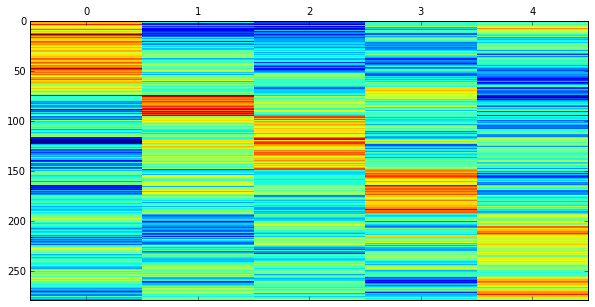

In [155]:
f = plt.figure(figsize=(10,5))
ax = f.add_subplot(111)
ax.matshow(weight_store[0,:, np.array(leaves)], aspect='auto')

In [157]:
sbt_store.shape

(7, 5, 45309)

In [158]:
m_img = nib.load('/data1/abide/Mask/mask_data_specific.nii.gz')
mask = m_img.get_data().astype(bool)
for i in range(5):
    vol = np.zeros_like(mask, dtype=float)
    vol[mask] = sbt_store[0, i, :]

    sbt_img = nib.Nifti1Image(vol, header=m_img.get_header(), affine=m_img.get_affine())
    nib.save(sbt_img, '/data1/abide/legacy_test/net1_sbt{}.nii.gz'.format(i))

In [16]:
cws.shape

(7, 5, 279)

In [17]:
cws[1,:,0:3]

array([[ 0.42272675,  0.24414086,  0.40144423],
       [-0.01223953,  0.07561443, -0.05657315],
       [-0.15065592, -0.01142983, -0.21538653],
       [ 0.01507455, -0.11389723,  0.03564303],
       [-0.15889201, -0.13051144, -0.05281404]])

In [23]:
np.corrcoef(weight_store[1,3,:], cws[1,4,:])[0,1]

0.87634150678708145

In [49]:
gdavg.shape

(53, 64, 52, 7)

In [125]:
part_store[0,1]

5.0

## Global Average

In [97]:
nss1 = nsm1['stack']

In [99]:
nss1.shape

(279, 45309)

In [100]:
nss1[0:3,0]

array([ 0.21343951,  0.32465902,  0.54649699])

In [85]:
nss1.shape

(279, 45309)

In [86]:
netraw = np.load(netraw_path)

In [110]:
nts1 = netraw[0,...]

In [119]:
nts1.shape

(45309, 279)

In [118]:
np.mean(nts1,0)[1]

0.15577008169489245

In [121]:
# Ok, get the first guy out
guy1 = '/data1/abide/legacy_test/old1.nii.gz'
m_img = nib.load('/data1/abide/Mask/mask_data_specific.nii.gz')
mask = m_img.get_data().astype(bool)
old_1 = np.zeros_like(mask, dtype=float)
old_1[mask] = nts1[:,0]

old_img = nib.Nifti1Image(old_1, header=m_img.get_header(), affine=m_img.get_affine())
nib.save(old_img, guy1)

In [111]:
nts1.shape

(45309, 279)

In [89]:
np.mean(nts1,0)[:3]

array([ 0.24811591,  0.23284709,  0.26083346])

In [90]:
np.mean(nss1,0)[:3]

array([ 0.34559671,  0.34687526,  0.34986084])

In [107]:
np.corrcoef(np.mean(nts1,0), np.mean(nss1,0))[0,1]

-0.01270546274656013

In [104]:
old_raw = '/data1/abide/legacy_test/old_raw.nii.gz'
new_raw = '/data1/abide/legacy_test/new_raw.nii.gz'
old = np.mean(nts1,0)
new = np.mean(nss1,0)

In [105]:
old.shape

(45309,)

In [106]:
new.shape

(45309,)

In [122]:
netstack_path

'/data1/subtypes/serial_preps/netstack_dmn_rmap_part_site_279_sample_scale_007.npy'

In [81]:
old_v = np.zeros_like(mask, dtype=float)
old_v[mask] = old
new_v = np.zeros_like(mask, dtype=float)
new_v[mask] = new

In [82]:
old_i = nib.Nifti1Image(old_v, header=m_img.get_header(), affine=m_img.get_affine())
new_i = nib.Nifti1Image(new_v, header=m_img.get_header(), affine=m_img.get_affine())

nib.save(old_i, old_raw)
nib.save(new_i, new_raw)